In [76]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import matplotlib.pyplot as plt 

import pretrainedmodels
import pretrainedmodels.utils

import matplotlib.image as mpimg
import ssl 
# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Since we don't have CPU
map_location=torch.device('cpu')

# Load the model 

In [77]:
class PretrainedResnetApparealDS(): 
    def __init__(self,weights_path = 'weights_finetuned.pth'): 
        self.weights_path = weights_path
        self.model_name = "se_resnext50_32x4d"
        self.num_classes = 101
        self.pretrained = None
        self.model = self.apply_finetuned_weights_to_model()
        
    def get_model_architecture(self):
        """ 
            Loads the structure of the original model 
        """
        model = pretrainedmodels.__dict__[self.model_name](pretrained=self.pretrained)
        dim_feats = model.last_linear.in_features
        model.last_linear = nn.Linear(dim_feats, self.num_classes)
        model.avg_pool = nn.AdaptiveAvgPool2d(1)
        return  model 

    def load_finetuned_weights(self):
        """
            Load the weights of the model fine tuned during the training (done on Onixya)
        """
        return torch.load(self.weights_path, map_location="cpu")
    
    def apply_finetuned_weights_to_model(self):
        """ 
            Applies the weights to the architecture of the initial model
        """
        model = self.get_model_architecture()
        weights = self.load_finetuned_weights()
        model.load_state_dict(weights['state_dict'])
        return model 

In [78]:
# Intanciate a class and retrived the model with the lattest fine tunned weights for the avg
pretrained_resnest_appareal_ds = PretrainedResnetApparealDS()
model = pretrained_resnest_appareal_ds.model

# Try the model 

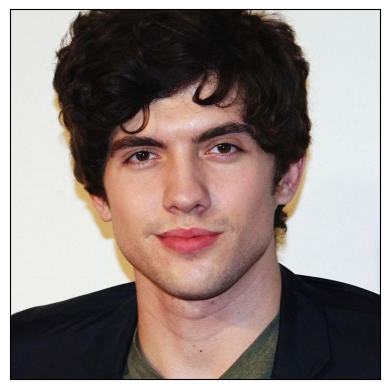

In [79]:
# Import a picture
image_test = mpimg.imread("appa-real-release/test/005616.jpg_face.jpg")
plt.imshow(image_test)
plt.xticks([])
plt.yticks([])
plt.show()

In [80]:
# Transfom the picture into a tensor
image_test_tensor = torch.from_numpy(image_test)
image_test_tensor = torch.permute(image_test_tensor, (2,0,1))
image_test_tensor = image_test_tensor.unsqueeze(0)
image_test_tensor = image_test_tensor.type(torch.float32)

In [81]:
# The model predict that the person is 25 years old
model(image_test_tensor).argmax()

tensor(28)

- 1  faire une montée de gradient (en déduirre une transformation) : une image test vs toutes les images test avec transformation spécifique
- 1bis modidifier toutes les images si on calcule qu'une seule attaque (sur une seule image)
- 2 tester le modèle avec ces images attaquées et voir si MEA à augmenter
- 3 attaquer tous les images train et ré-entraîner le modèle sur Onixia (avec du gros GPU sa mère)
- 4 retester sur les images test que l'on avait et celle qui ne le sont pas pour voir si 

# Image attack : gradient ascent 

### 1 - Test an attack on 1 image

In [ ]:
# We are going to make a gradient ascent on the image space, meanding thatt the pixels of the image 
# will be modified to maximize the defined
image_test_tensor

In [119]:
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to("cpu")
    if isinstance(std, list):
        std = torch.tensor(std).to("cpu")

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [120]:
#model(image_test_tensor)

image_test_tensor.requires_grad = True
output = model(image_test_tensor)
#init_pred = output.max(1, keepdim=True)[1]
loss = - torch.nn.functional.cross_entropy(output,torch.tensor([23]))

model.zero_grad()

# Calculate gradients of model in backward pass
loss.backward()

# Collect ``datagrad``
data_grad = image_test_tensor.grad.data

data_denorm = denorm(image_test_tensor)


perturbed_data = fgsm_attack(data_denorm, 0.007, data_grad)
# Reapply normalization
perturbed_data_normalized = torchvision.transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

Text(0.5, 1.0, 'attacked image')

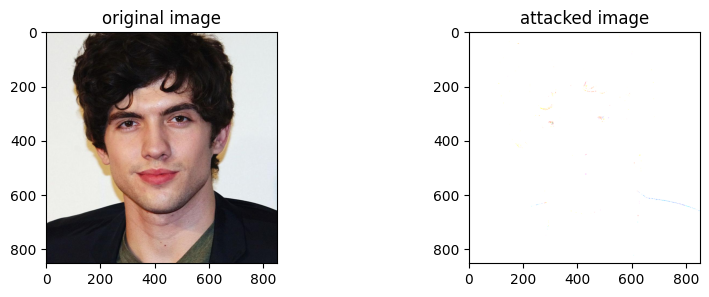

In [121]:
_, axes = plt.subplots(1,2, figsize = (10,3))

axes[0].imshow(image_test)
axes[0].set_title("original image")
axes[1].imshow(perturbed_data.squeeze().permute(1,2,0).detach().numpy())
axes[1].set_title("attacked image")

In [103]:
perturbed_data.squeeze().permute(1,2,0).shape

torch.Size([852, 852, 3])

In [94]:

def fgsm_attack(image, epsilon, data_grad):
    """ 
    (from pytorch documentations)
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image